<a href="https://www.kaggle.com/code/marinanasser/breakhis-notebook-ipynb?scriptVersionId=271213313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/marygamal/breakhis-notebook?scriptVersionId=270834138" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/

In [ ]:
# ================================================================
# 📦 IMPORTS & GLOBAL CONFIG
# ================================================================
import os, re, random, itertools
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


2025-10-27 08:16:28.850964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761552988.873923    4359 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761552988.880991    4359 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Build dataframe of images

In [ ]:
# ================================================================
# 🧠 DATASET PREPARATION
# ================================================================
def parse_breakhis_path(p: str):
    fname = os.path.basename(p)
    parts = fname.split('_')
    label_token = parts[1] if len(parts) > 1 else ''
    label = 'benign' if label_token.upper().startswith('B') else 'malignant'
    mag = Path(p).parents[0].name
    try:
        third = parts[2]
        patient = third.rsplit('-', 2)[0]
    except Exception:
        m = re.search(r'([A-Za-z]-\d+-\w+)', fname)
        patient = m.group(1) if m else fname
    return label, mag, patient

def patient_stratified_split(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=SEED):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
    splits = {}
    for mag in df['mag'].unique():
        sub = df[df['mag']==mag].copy()
        patients = sub['patient_id'].unique().tolist()
        random.Random(seed).shuffle(patients)
        n = len(patients)
        n_train = int(round(train_frac * n))
        n_val = int(round(val_frac * n))
        train_pat = set(patients[:n_train])
        val_pat = set(patients[n_train:n_train+n_val])
        test_pat = set(patients[n_train+n_val:])
        splits[mag] = {
            'train': sub[sub['patient_id'].isin(train_pat)],
            'val': sub[sub['patient_id'].isin(val_pat)],
            'test': sub[sub['patient_id'].isin(test_pat)]
        }
    return splits

# ================================================================
# 🧩 DATASET UTILITIES
# ================================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = ['benign', 'malignant']
label_to_idx = {c:i for i,c in enumerate(CLASS_NAMES)}

def path_to_tensor(path, img_size=IMG_SIZE, preprocess=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    img = preprocess(img) if preprocess else img / 255.0
    return img

data_augment = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05, 0.05),
])

def df_to_tf_dataset(df, preprocess=None, shuffle=False, repeat=False):
    paths = df['filepath'].values
    labels = [label_to_idx[l] for l in df['label'].values]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    def _load(path, label):
        return path_to_tensor(path, IMG_SIZE, preprocess), label
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# ================================================================
# 🏗️ MODEL ARCHITECTURES
# ================================================================
def build_custom_cnn(input_shape=(*IMG_SIZE,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)
    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs, name='custom_cnn')

def build_enhanced_cnn(input_shape=(*IMG_SIZE,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = layers.RandomFlip('horizontal_and_vertical')(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.15)(x)
    x = layers.RandomContrast(0.1)(x)
    for filters, dropout in [(64,0.3),(128,0.4)]:
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(dropout)(x)
    x = layers.SeparableConv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs, name='enhanced_cnn')

def build_mobilenet_v2(input_shape=(*IMG_SIZE,3), num_classes=2, trainable_base=False):
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')
    base.trainable = trainable_base
    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs, name='mobilenet_v2_tl')

# ================================================================
# ⚙️ TRAINING & EVALUATION HELPERS
# ================================================================
def compile_and_train(model, train_ds, val_ds, epochs=20, model_name='model', patience=4, class_weight=None):
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    cbs = [
        callbacks.ModelCheckpoint(f'{model_name}.h5', save_best_only=True, monitor='val_loss'),
        callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    ]
    return model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, class_weight=class_weight)

def evaluate_and_report(model, df_test, preprocess=None):
    ds = df_to_tf_dataset(df_test, preprocess=preprocess)
    preds = model.predict(ds)
    y_pred = np.argmax(preds, axis=1)
    y_true = [label_to_idx[l] for l in df_test['label']]
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    return confusion_matrix(y_true, y_pred), y_true, y_pred

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], ha="center", color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
    plt.show()

def plot_training_history(history, model_name='Model'):
    fig, (a1,a2)=plt.subplots(1,2,figsize=(12,4))
    a1.plot(history.history['accuracy']); a1.plot(history.history['val_accuracy'])
    a1.set_title(f'{model_name} - Accuracy'); a1.legend(['Train','Val'])
    a2.plot(history.history['loss']); a2.plot(history.history['val_loss'])
    a2.set_title(f'{model_name} - Loss'); a2.legend(['Train','Val'])
    plt.show()

def calculate_metrics(cm, model_name):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:    {accuracy:.3f}")
    print(f"  Precision:   {precision:.3f}")
    print(f"  Recall:      {recall:.3f}")
    print(f"  Specificity: {specificity:.3f}")
    print(f"  F1-Score:    {f1:.3f}")
    print(f"  Confusion Matrix:\n{cm}")

I0000 00:00:1761552992.357772    4359 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761552992.358484    4359 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
base_input = Path('/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast')
image_paths = sorted([str(p) for p in base_input.rglob('*.png')])

# Parse dataset
rows = [
    dict(
        filepath=p,
        label=parse_breakhis_path(p)[0],
        mag=parse_breakhis_path(p)[1],
        patient_id=parse_breakhis_path(p)[2]
    )
    for p in image_paths
]
df = pd.DataFrame(rows)
df['mag'] = df['mag'].str.upper().str.replace(' ', '')
df = df[df['mag'].isin(['40X', '200X'])].reset_index(drop=True)

# Stratified split by patient for both magnifications
splits = patient_stratified_split(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=42)

print("✅ Dataset loaded and split for magnifications:", df['mag'].unique())


✅ Dataset loaded and split for magnifications: ['200X' '40X']


Total images (40x and 200x): 4008
200X {'train': 1329, 'val': 173, 'test': 511}
40X {'train': 1350, 'val': 191, 'test': 454}

=== 200X ===
train | images: 1329 | patients:  57
  val | images:  173 | patients:   8
 test | images:  511 | patients:  17

=== 40X ===
train | images: 1350 | patients:  57
  val | images:  191 | patients:   8
 test | images:  454 | patients:  17
Num GPUs Available: 2
Running on: GPU

Processing 40X
Counts: 1350 191 454

Calculating class weights...
Class distribution - Benign: 453, Malignant: 897
Class weights - Benign: 1.49, Malignant: 0.75

TRAINING ENHANCED CUSTOM CNN WITH CLASS WEIGHTS
Epoch 1/50


E0000 00:00:1761553004.849430    4359 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/enhanced_cnn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761553007.697432    4410 cuda_dnn.cc:529] Loaded cuDNN version 90300


43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - accuracy: 0.6398 - loss: 0.8731 - val_accuracy: 1.0000 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step - accuracy: 0.7328 - loss: 0.6597 - val_accuracy: 1.0000 - val_loss: 0.5248 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.7403 - loss: 0.6385 - val_accuracy: 1.0000 - val_loss: 0.4279 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.7524 - loss: 0.5827 - val_accuracy: 1.0000 - val_loss: 0.3597 - learning_rate: 1.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.7622 - loss: 0.5590 - val_accuracy: 1.0000 - val_loss: 0.2770 - learning_rate: 1.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.7566 - loss: 0.5398 - val_accuracy: 1.0000 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - accuracy: 0.77

E0000 00:00:1761553224.798600    4359 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_cnn_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.6550 - loss: 0.6365 - val_accuracy: 1.0000 - val_loss: 0.5430 - learning_rate: 1.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7829 - loss: 0.5082 - val_accuracy: 1.0000 - val_loss: 0.4301 - learning_rate: 1.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.7640 - loss: 0.5001 - val_accuracy: 1.0000 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8174 - loss: 0.4357 - val_accuracy: 1.0000 - val_loss: 0.2897 - learning_rate: 1.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7986 - loss: 0.4478 - val_accuracy: 1.0000 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.8211 - loss: 0.4264 - val_accuracy: 1.0000 - val_loss: 0.1928 - learning_rate: 1.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.8182 - l

I0000 00:00:1761553313.850639    4411 service.cc:148] XLA service 0x7854ec1867a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761553313.850702    4411 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761553313.850707    4411 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 5/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6335 - loss: 0.7505

I0000 00:00:1761553318.339161    4411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 342ms/step - accuracy: 0.6375 - loss: 0.6679 - val_accuracy: 0.6911 - val_loss: 0.6123 - learning_rate: 1.0000e-04
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.7780 - loss: 0.4546 - val_accuracy: 0.7749 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8629 - loss: 0.3588 - val_accuracy: 0.7906 - val_loss: 0.4641 - learning_rate: 1.0000e-04
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8849 - loss: 0.3023 - val_accuracy: 0.7487 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9165 - loss: 0.2503 - val_accuracy: 0.7173 - val_loss: 0.5712 - learning_rate: 1.0000e-04
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9226 - loss: 0.2302 - val_accuracy: 0.7906 - val_loss: 0.4592 - learning_rate: 5.0000e-05
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9363 - l

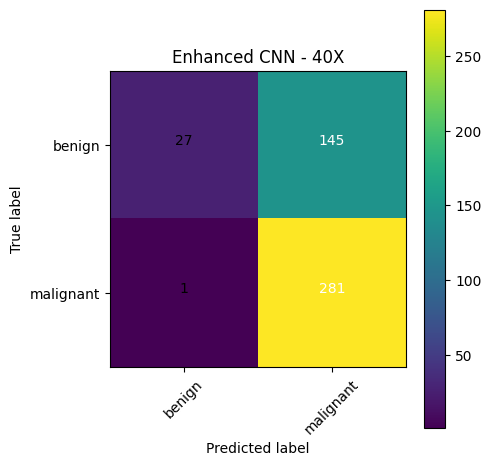

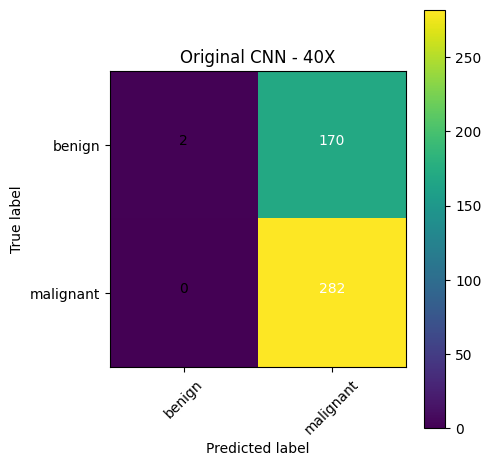

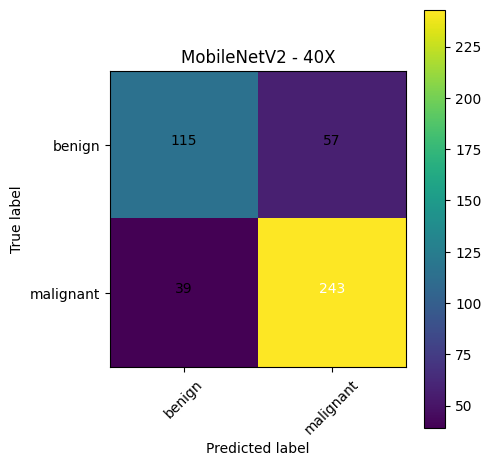


TRAINING HISTORIES
Enhanced CNN Training History (40X):


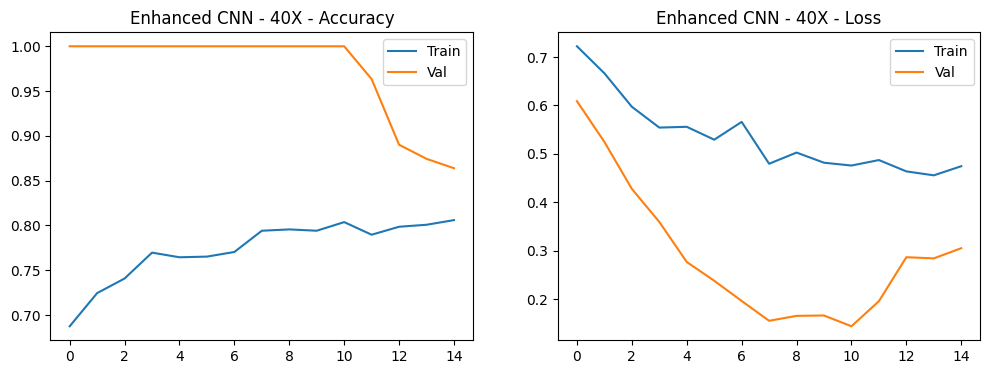

Original CNN Training History (40X):


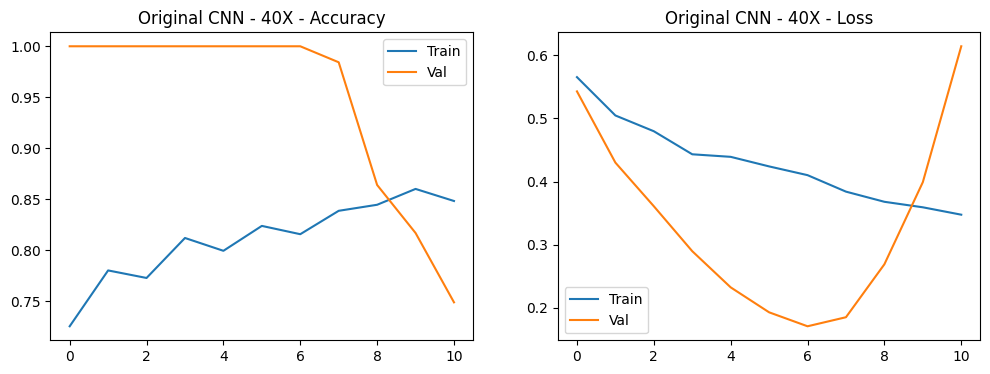

MobileNetV2 Training History (40X):


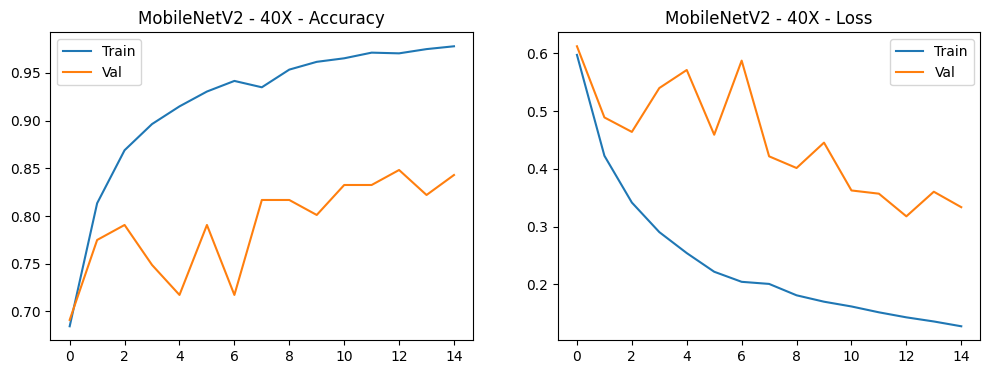

MobileNetV2 Fine-tuned Training History (40X):


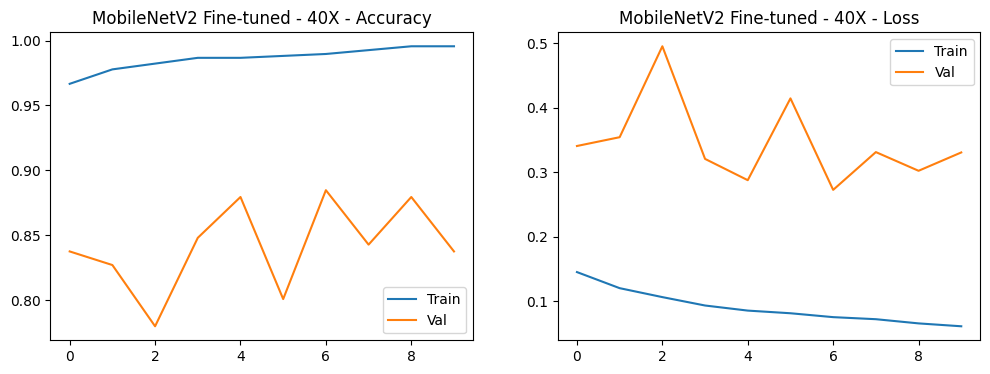


PERFORMANCE SUMMARY

Enhanced Custom CNN:
  Accuracy:    0.678
  Precision:   0.660
  Recall:      0.996
  Specificity: 0.157
  F1-Score:    0.794
  Confusion Matrix:
[[ 27 145]
 [  1 281]]

Original Custom CNN:
  Accuracy:    0.626
  Precision:   0.624
  Recall:      1.000
  Specificity: 0.012
  F1-Score:    0.768
  Confusion Matrix:
[[  2 170]
 [  0 282]]

MobileNetV2:
  Accuracy:    0.789
  Precision:   0.810
  Recall:      0.862
  Specificity: 0.669
  F1-Score:    0.835
  Confusion Matrix:
[[115  57]
 [ 39 243]]

TRAINING COMPLETE!

MODEL ARCHITECTURE SUMMARIES

ENHANCED CUSTOM CNN ARCHITECTURE SUMMARY


Model: "enhanced_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 56, 56, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           25

 Total params: 145,282 (567.51 KB)

 Trainable params: 144,130 (563.01 KB)

 Non-trainable params: 1,152 (4.50 KB)


ORIGINAL CUSTOM CNN ARCHITECTURE SUMMARY


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,682 (498.76 KB)

 Trainable params: 127,234 (497.01 KB)

 Non-trainable params: 448 (1.75 KB)


MOBILENET V2 ARCHITECTURE SUMMARY


Model: "mobilenet_v2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


MOBILENET V2 FINE-TUNED ARCHITECTURE SUMMARY


Model: "mobilenet_v2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 2,552,322 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Define the base directory containing the BreakHis dataset
base_input = Path('/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast')
# Recursively find all PNG images and store their paths as strings
image_paths = sorted([str(p) for p in base_input.rglob('*.png')])

len(image_paths)  # Count total number of images found

# Create dataframe to store image metadata
rows = []
for p in image_paths:
    label, mag, patient = parse_breakhis_path(p)
    rows.append({'filepath': p, 'label': label, 'mag': mag, 'patient_id': patient})
df = pd.DataFrame(rows)
# Clean and standardize magnification values
df['mag'] = df['mag'].str.upper().str.replace(' ', '')
# Filter to only include 40X and 200X magnifications
df = df[df['mag'].isin(['40X', '200X'])].reset_index(drop=True)
print("Total images (40x and 200x):", len(df))
df.sample(5)  # Display 5 random samples from the dataframe


# Create the patient-stratified splits
splits = patient_stratified_split(df, 0.7, 0.1, 0.2)
# Print split statistics for each magnification
for mag in splits:
    print(mag, {k: len(v) for k,v in splits[mag].items()})

# Display detailed split information
for mag in splits:
    print(f"\n=== {mag} ===")
    for split_name, split_df in splits[mag].items():
        n_images = len(split_df)
        n_patients = split_df['patient_id'].nunique()
        print(f"{split_name:>5} | images: {n_images:4d} | patients: {n_patients:3d}")

# Check GPU availability and set environment
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# Force CPU usage (comment out to use GPU if available)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Running on:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

# Process 40X magnification images
mag = '40X'
print(f"\n{'='*50}\nProcessing {mag}\n{'='*50}")
# Get splits for current magnification
train_df = splits[mag]['train'].reset_index(drop=True)
val_df   = splits[mag]['val'].reset_index(drop=True)
test_df  = splits[mag]['test'].reset_index(drop=True)
print("Counts:", len(train_df), len(val_df), len(test_df))

# Calculate class weights to handle imbalance
print("\nCalculating class weights...")
train_labels = train_df['label'].map({'benign': 0, 'malignant': 1})
benign_count = np.sum(train_labels == 0)
malignant_count = np.sum(train_labels == 1)
total = benign_count + malignant_count

# Give more weight to the minority class (benign)
class_weight = {
    0: total / (2 * benign_count),   # Higher weight for benign
    1: total / (2 * malignant_count) # Lower weight for malignant
}
print(f"Class distribution - Benign: {benign_count}, Malignant: {malignant_count}")
print(f"Class weights - Benign: {class_weight[0]:.2f}, Malignant: {class_weight[1]:.2f}")

# Create datasets for custom CNN (no special preprocessing)
train_ds = df_to_tf_dataset(train_df, preprocess=None, shuffle=True, repeat=False)
val_ds   = df_to_tf_dataset(val_df, preprocess=None, shuffle=False)
test_ds  = df_to_tf_dataset(test_df, preprocess=None, shuffle=False)

# Create datasets for MobileNet (with MobileNet-specific preprocessing)
train_ds_mob = df_to_tf_dataset(train_df, preprocess=mobilenet_preprocess, shuffle=True, repeat=False)
val_ds_mob   = df_to_tf_dataset(val_df, preprocess=mobilenet_preprocess, shuffle=False)
test_ds_mob  = df_to_tf_dataset(test_df, preprocess=mobilenet_preprocess, shuffle=False)

# Train Enhanced Custom CNN with class weights
print("\n" + "="*60)
print("TRAINING ENHANCED CUSTOM CNN WITH CLASS WEIGHTS")
print("="*60)
enhanced_cnn = build_enhanced_cnn()
enhanced_history = compile_and_train(
    enhanced_cnn, 
    train_ds, 
    val_ds, 
    epochs=50, 
    model_name=f'enhanced_cnn_{mag.lower()}',
    class_weight=class_weight
)

# Also train original CNN for comparison
print("\n" + "="*60)
print("TRAINING ORIGINAL CUSTOM CNN WITH CLASS WEIGHTS")
print("="*60)
custom_cnn = build_custom_cnn()
custom_history = compile_and_train(
    custom_cnn, 
    train_ds, 
    val_ds, 
    epochs=50, 
    model_name=f'custom_cnn_{mag.lower()}',
    class_weight=class_weight
)

# Build and train MobileNetV2 with transfer learning
print("\n" + "="*60)
print("TRAINING MOBILENET V2 WITH CLASS WEIGHTS")
print("="*60)
mobilenet = build_mobilenet_v2(trainable_base=False)
mobilenet_history = compile_and_train(
    mobilenet, 
    train_ds_mob, 
    val_ds_mob, 
    epochs=15, 
    model_name=f'mobilenet_{mag.lower()}',
    class_weight=class_weight
)

# Fine-tuning: unfreeze some layers for additional training
print("\n" + "="*60)
print("FINE-TUNING MOBILENET V2")
print("="*60)
mobilenet.trainable = True
# Freeze early layers, unfreeze later layers for fine-tuning
for layer in mobilenet.layers[:-20]:
    layer.trainable = False

mobilenet_history_ft = compile_and_train(
    mobilenet, 
    train_ds_mob, 
    val_ds_mob, 
    epochs=10, 
    model_name=f'mobilenet_{mag.lower()}_finetuned', 
    patience=3,
    class_weight=class_weight
)

# =============================================================================
# EVALUATION AND VISUALIZATION
# =============================================================================

# Evaluate all models on test set
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nEnhanced Custom CNN ({mag}) evaluation:")
cm_enhanced, y_true_enhanced, y_pred_enhanced = evaluate_and_report(enhanced_cnn, test_df)

print(f"\nOriginal Custom CNN ({mag}) evaluation:")
cm_custom, y_true_custom, y_pred_custom = evaluate_and_report(custom_cnn, test_df)

print(f"\nMobileNet ({mag}) evaluation:")
cm_mobilenet, y_true_mob, y_pred_mob = evaluate_and_report(mobilenet, test_df, preprocess=mobilenet_preprocess)


# Plot confusion matrices for all models
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

plot_confusion_matrix(cm_enhanced, CLASS_NAMES, title=f'Enhanced CNN - {mag}')
plot_confusion_matrix(cm_custom, CLASS_NAMES, title=f'Original CNN - {mag}')
plot_confusion_matrix(cm_mobilenet, CLASS_NAMES, title=f'MobileNetV2 - {mag}')


# Plot training histories for all models
print("\n" + "="*60)
print("TRAINING HISTORIES")
print("="*60)

print(f"Enhanced CNN Training History ({mag}):")
plot_training_history(enhanced_history, f'Enhanced CNN - {mag}')

print(f"Original CNN Training History ({mag}):")
plot_training_history(custom_history, f'Original CNN - {mag}')

print(f"MobileNetV2 Training History ({mag}):")
plot_training_history(mobilenet_history, f'MobileNetV2 - {mag}')

print(f"MobileNetV2 Fine-tuned Training History ({mag}):")
plot_training_history(mobilenet_history_ft, f'MobileNetV2 Fine-tuned - {mag}')

# =============================================================================
# PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

calculate_metrics(cm_enhanced, "Enhanced Custom CNN")
calculate_metrics(cm_custom, "Original Custom CNN")
calculate_metrics(cm_mobilenet, "MobileNetV2")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

# =============================================================================
# MODEL ARCHITECTURE SUMMARIES
# =============================================================================

print("\n" + "="*80)
print("MODEL ARCHITECTURE SUMMARIES")
print("="*80)

# Enhanced Custom CNN Summary
print("\n" + "="*50)
print("ENHANCED CUSTOM CNN ARCHITECTURE SUMMARY")
print("="*50)
enhanced_cnn_summary = build_enhanced_cnn()
enhanced_cnn_summary.summary()

# Original Custom CNN Summary  
print("\n" + "="*50)
print("ORIGINAL CUSTOM CNN ARCHITECTURE SUMMARY")
print("="*50)
custom_cnn_summary = build_custom_cnn()
custom_cnn_summary.summary()

# MobileNetV2 Summary
print("\n" + "="*50)
print("MOBILENET V2 ARCHITECTURE SUMMARY")
print("="*50)
mobilenet_summary = build_mobilenet_v2(trainable_base=False)
mobilenet_summary.summary()

# MobileNetV2 Fine-tuned Summary
print("\n" + "="*50)
print("MOBILENET V2 FINE-TUNED ARCHITECTURE SUMMARY")
print("="*50)
mobilenet_ft_summary = build_mobilenet_v2(trainable_base=True)
# Freeze early layers for fine-tuning
for layer in mobilenet_ft_summary.layers[:-20]:
    layer.trainable = False
mobilenet_ft_summary.summary()


Processing 200X
Counts: 1329 173 511
Class distribution - Benign: 426, Malignant: 903
Class weights - Benign: 1.56, Malignant: 0.74

TRAINING ENHANCED CUSTOM CNN (200X)
Epoch 1/50


E0000 00:00:1761553507.453988    4359 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/enhanced_cnn_1/dropout_16_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6489 - loss: 0.6716 - val_accuracy: 1.0000 - val_loss: 0.6860 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - accuracy: 0.7921 - loss: 0.4375 - val_accuracy: 1.0000 - val_loss: 0.6417 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.8201 - loss: 0.4058 - val_accuracy: 1.0000 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.8193 - loss: 0.3712 - val_accuracy: 1.0000 - val_loss: 0.5938 - learning_rate: 1.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step - accuracy: 0.8321 - loss: 0.3743 - val_accuracy: 0.9884 - val_loss: 0.6139 - learning_rate: 1.0000e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.8481 - loss: 0.3700 - val_accuracy: 0.8728 - val_loss: 0.6003 - learning_rate: 1.0000e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.84

E0000 00:00:1761553804.036861    4359 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_cnn_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.7230 - loss: 0.7477 - val_accuracy: 1.0000 - val_loss: 0.6584 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8193 - loss: 0.4007 - val_accuracy: 1.0000 - val_loss: 0.5581 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.8198 - loss: 0.3870 - val_accuracy: 1.0000 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8596 - loss: 0.3212 - val_accuracy: 1.0000 - val_loss: 0.3153 - learning_rate: 1.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.8609 - loss: 0.3018 - val_accuracy: 1.0000 - val_loss: 0.2244 - learning_rate: 1.0000e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8723 - loss: 0.2976 - val_accuracy: 1.0000 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8849 - l

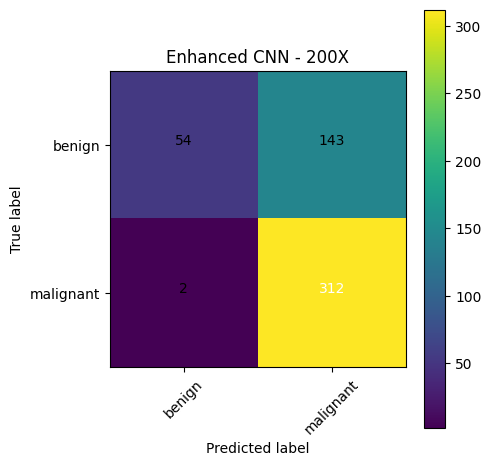

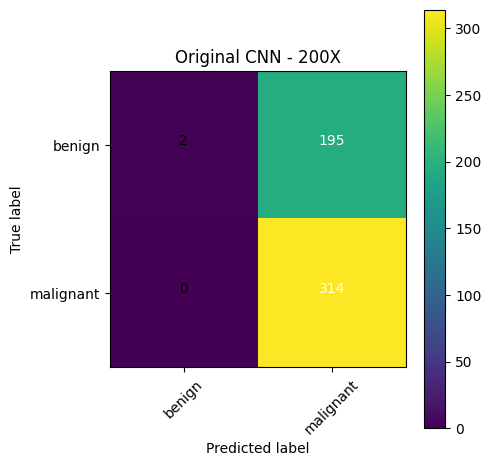

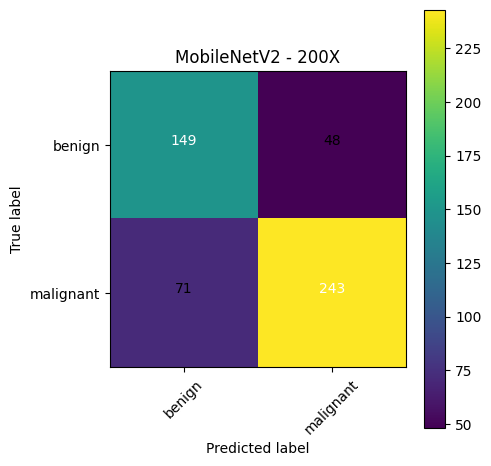

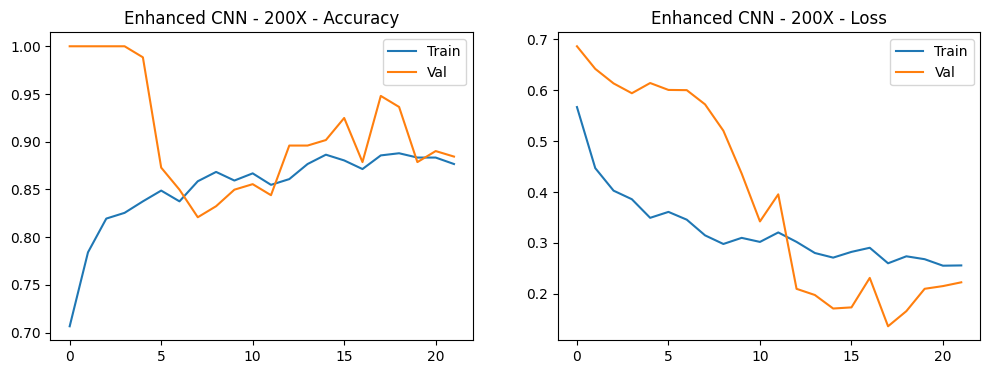

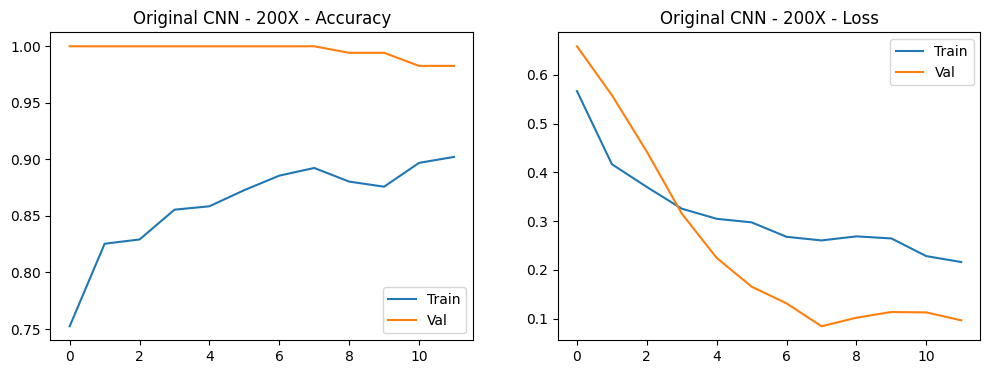

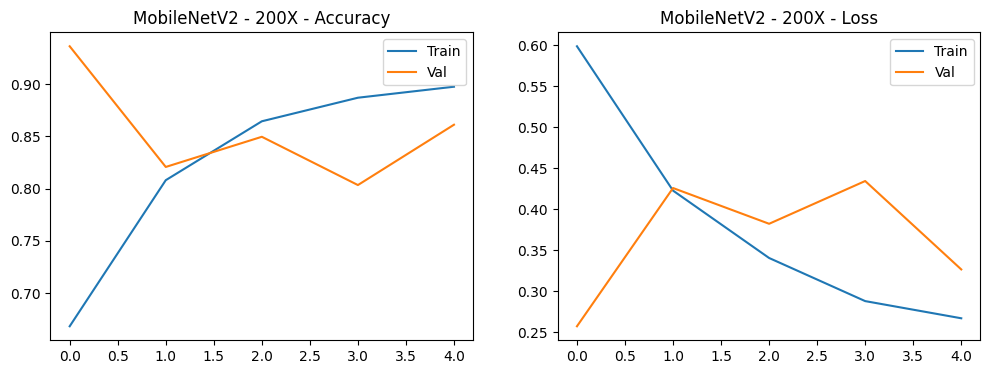

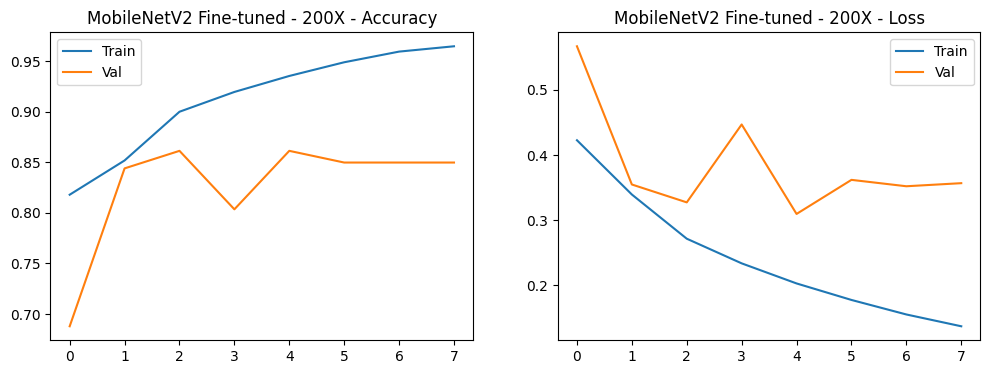

In [ ]:
# =============================================================================
# RUN 200X MAGNIFICATION EXPERIMENT
# =============================================================================

mag = '200X'
print(f"\n{'='*50}\nProcessing {mag}\n{'='*50}")
train_df = splits[mag]['train'].reset_index(drop=True)
val_df   = splits[mag]['val'].reset_index(drop=True)
test_df  = splits[mag]['test'].reset_index(drop=True)
print("Counts:", len(train_df), len(val_df), len(test_df))

# Calculate class weights for 200X
train_labels = train_df['label'].map({'benign': 0, 'malignant': 1})
benign_count = np.sum(train_labels == 0)
malignant_count = np.sum(train_labels == 1)
total = benign_count + malignant_count

class_weight = {
    0: total / (2 * benign_count),
    1: total / (2 * malignant_count)
}
print(f"Class distribution - Benign: {benign_count}, Malignant: {malignant_count}")
print(f"Class weights - Benign: {class_weight[0]:.2f}, Malignant: {class_weight[1]:.2f}")

# Prepare TensorFlow datasets
train_ds = df_to_tf_dataset(train_df, preprocess=None, shuffle=True, repeat=False)
val_ds   = df_to_tf_dataset(val_df, preprocess=None, shuffle=False)
test_ds  = df_to_tf_dataset(test_df, preprocess=None, shuffle=False)

train_ds_mob = df_to_tf_dataset(train_df, preprocess=mobilenet_preprocess, shuffle=True, repeat=False)
val_ds_mob   = df_to_tf_dataset(val_df, preprocess=mobilenet_preprocess, shuffle=False)
test_ds_mob  = df_to_tf_dataset(test_df, preprocess=mobilenet_preprocess, shuffle=False)

# Train Enhanced CNN
print("\n" + "="*60)
print("TRAINING ENHANCED CUSTOM CNN (200X)")
print("="*60)
enhanced_cnn_200x = build_enhanced_cnn()
history_enhanced_200x = compile_and_train(
    enhanced_cnn_200x,
    train_ds,
    val_ds,
    epochs=50,
    model_name='enhanced_cnn_200x',
    class_weight=class_weight
)

# Train Original CNN
print("\n" + "="*60)
print("TRAINING ORIGINAL CUSTOM CNN (200X)")
print("="*60)
custom_cnn_200x = build_custom_cnn()
history_custom_200x = compile_and_train(
    custom_cnn_200x,
    train_ds,
    val_ds,
    epochs=50,
    model_name='custom_cnn_200x',
    class_weight=class_weight
)

# Train MobileNetV2
print("\n" + "="*60)
print("TRAINING MOBILENETV2 (200X)")
print("="*60)
mobilenet_200x = build_mobilenet_v2(trainable_base=False)
history_mobilenet_200x = compile_and_train(
    mobilenet_200x,
    train_ds_mob,
    val_ds_mob,
    epochs=15,
    model_name='mobilenet_200x',
    class_weight=class_weight
)

# Fine-tuning MobileNetV2
print("\n" + "="*60)
print("FINE-TUNING MOBILENETV2 (200X)")
print("="*60)
mobilenet_200x.trainable = True
for layer in mobilenet_200x.layers[:-20]:
    layer.trainable = False

history_mobilenet_ft_200x = compile_and_train(
    mobilenet_200x,
    train_ds_mob,
    val_ds_mob,
    epochs=10,
    model_name='mobilenet_200x_finetuned',
    patience=3,
    class_weight=class_weight
)

# Evaluation
print("\n" + "="*60)
print("EVALUATION RESULTS (200X)")
print("="*60)
print(f"\nEnhanced CNN ({mag}) Evaluation:")
cm_enh_200x, _, _ = evaluate_and_report(enhanced_cnn_200x, test_df)

print(f"\nOriginal CNN ({mag}) Evaluation:")
cm_cust_200x, _, _ = evaluate_and_report(custom_cnn_200x, test_df)

print(f"\nMobileNetV2 ({mag}) Evaluation:")
cm_mob_200x, _, _ = evaluate_and_report(mobilenet_200x, test_df, preprocess=mobilenet_preprocess)

# Confusion Matrices
plot_confusion_matrix(cm_enh_200x, CLASS_NAMES, title=f'Enhanced CNN - {mag}')
plot_confusion_matrix(cm_cust_200x, CLASS_NAMES, title=f'Original CNN - {mag}')
plot_confusion_matrix(cm_mob_200x, CLASS_NAMES, title=f'MobileNetV2 - {mag}')

# Training Histories
plot_training_history(history_enhanced_200x, f'Enhanced CNN - {mag}')
plot_training_history(history_custom_200x, f'Original CNN - {mag}')
plot_training_history(history_mobilenet_200x, f'MobileNetV2 - {mag}')
plot_training_history(history_mobilenet_ft_200x, f'MobileNetV2 Fine-tuned - {mag}')


In [ ]:
calculate_metrics(cm_enh_200x, "Enhanced Custom CNN")
calculate_metrics(cm_cust_200x, "Original Custom CNN")
calculate_metrics(cm_mob_200x, "MobileNetV2")


Enhanced Custom CNN:
  Accuracy:    0.716
  Precision:   0.686
  Recall:      0.994
  Specificity: 0.274
  F1-Score:    0.811
  Confusion Matrix:
[[ 54 143]
 [  2 312]]

Original Custom CNN:
  Accuracy:    0.618
  Precision:   0.617
  Recall:      1.000
  Specificity: 0.010
  F1-Score:    0.763
  Confusion Matrix:
[[  2 195]
 [  0 314]]

MobileNetV2:
  Accuracy:    0.767
  Precision:   0.835
  Recall:      0.774
  Specificity: 0.756
  F1-Score:    0.803
  Confusion Matrix:
[[149  48]
 [ 71 243]]
